# DETR - Transformer model for Table Detection

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

!sudo apt install tesseract-ocr

!pip install -q timm pytesseract

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~

# Import

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output

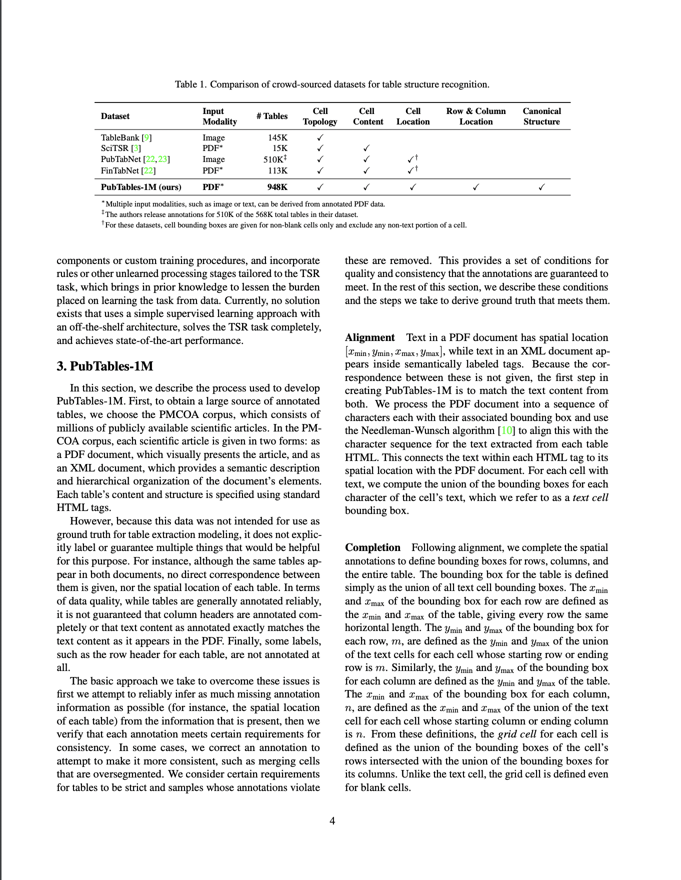

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_pdf.png")
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

# Initialize Model

In [ ]:


from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [ ]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1033, 800])


In [ ]:

from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

# Table Detection

In [ ]:


# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]


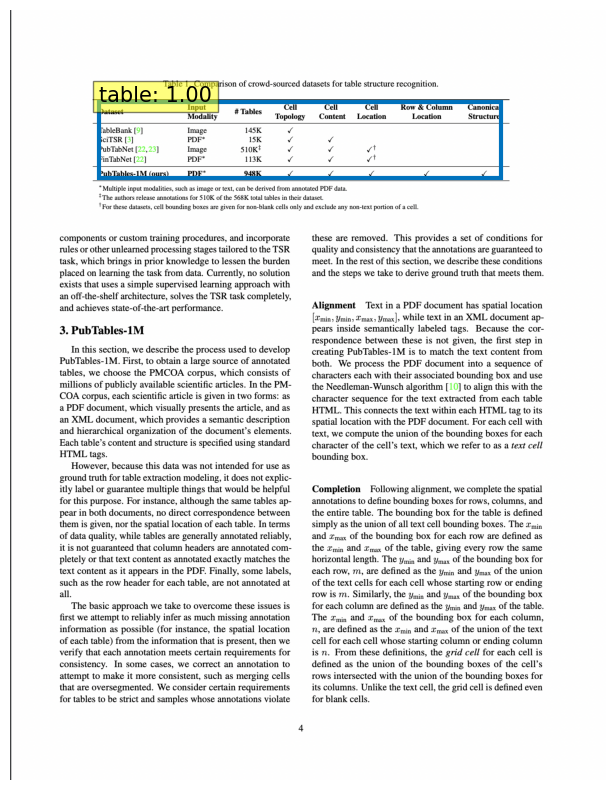

In [ ]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

# Table Structure Detection

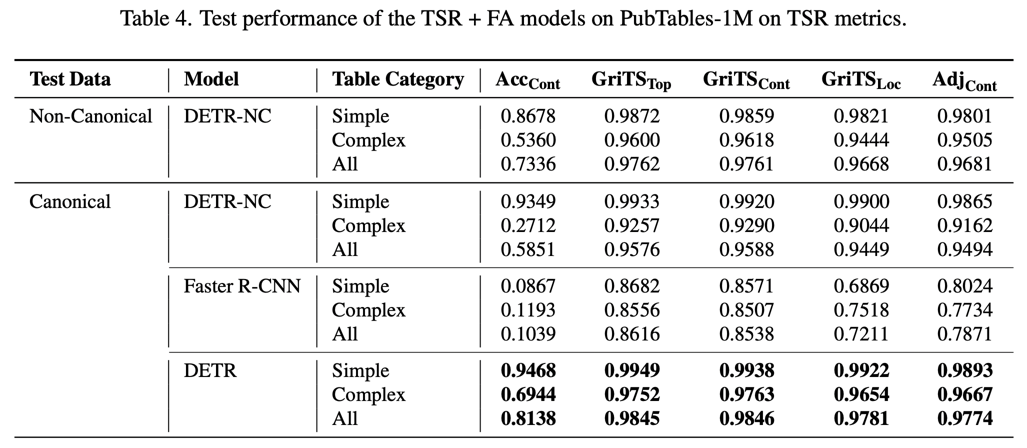

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_table.png")
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [ ]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [ ]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

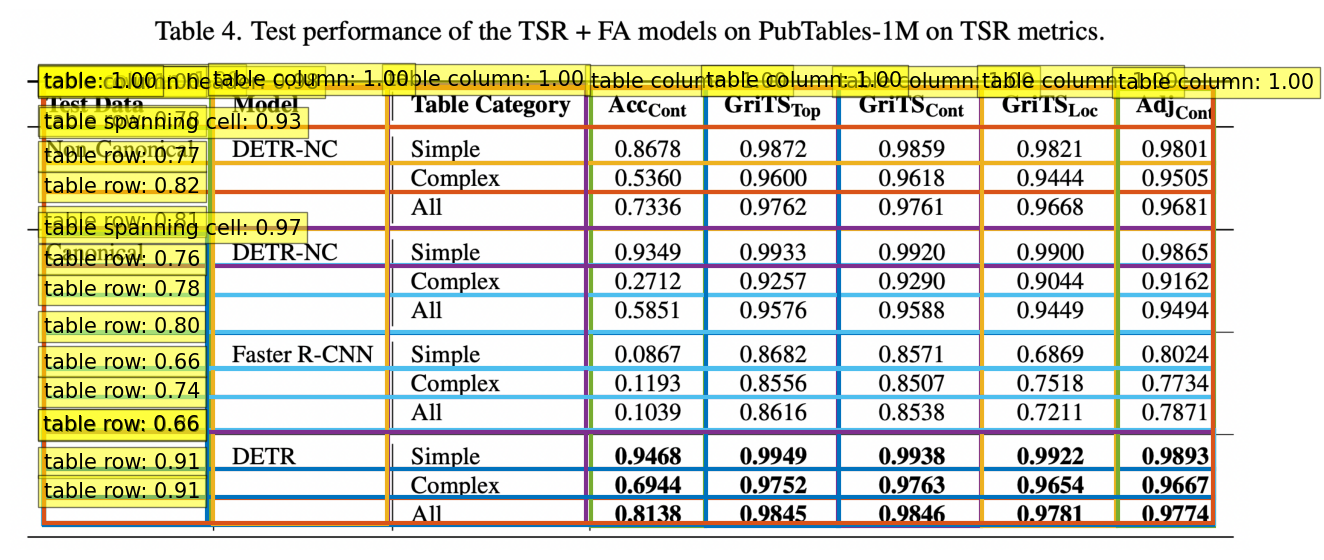

In [ ]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [ ]:
results

{'scores': tensor([0.7818, 0.9094, 0.8190, 0.9996, 0.9995, 0.7614, 0.9992, 0.7655, 0.7816,
         0.8138, 0.9999, 0.7961, 0.8562, 0.9973, 0.9996, 0.9995, 0.9995, 0.6596,
         0.9082, 0.9802, 0.9996, 0.7440, 0.9283, 0.6625, 0.9690, 1.0000]),
 'labels': tensor([2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 3, 1, 2, 5, 2,
         5, 0]),
 'boxes': tensor([[  55.1625,  473.8491, 1992.9238,  536.2683],
         [  55.4169,  760.5422, 1993.0583,  808.9153],
         [  55.5170,  302.8054, 1993.0104,  364.1293],
         [1370.9203,  128.7774, 1607.9895,  856.0112],
         [ 961.6448,  128.3521, 1151.3483,  855.8168],
         [  55.3619,  423.8597, 1993.0262,  472.4117],
         [1153.1301,  127.8595, 1372.5353,  855.7993],
         [  55.5993,  253.6965, 1993.0969,  302.4271],
         [  55.4433,  194.0559, 1993.0710,  253.7692],
         [  55.7711,  361.3059, 1992.7142,  424.7832],
         [  55.7679,  126.7103,  331.8651,  853.5883],
         [  55.1420,  534.7481,

# Extraction

In [ ]:
label_dict = model.config.id2label
label_dict

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [ ]:
results

{'scores': tensor([0.7818, 0.9094, 0.8190, 0.9996, 0.9995, 0.7614, 0.9992, 0.7655, 0.7816,
         0.8138, 0.9999, 0.7961, 0.8562, 0.9973, 0.9996, 0.9995, 0.9995, 0.6596,
         0.9082, 0.9802, 0.9996, 0.7440, 0.9283, 0.6625, 0.9690, 1.0000]),
 'labels': tensor([2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 3, 1, 2, 5, 2,
         5, 0]),
 'boxes': tensor([[  55.1625,  473.8491, 1992.9238,  536.2683],
         [  55.4169,  760.5422, 1993.0583,  808.9153],
         [  55.5170,  302.8054, 1993.0104,  364.1293],
         [1370.9203,  128.7774, 1607.9895,  856.0112],
         [ 961.6448,  128.3521, 1151.3483,  855.8168],
         [  55.3619,  423.8597, 1993.0262,  472.4117],
         [1153.1301,  127.8595, 1372.5353,  855.7993],
         [  55.5993,  253.6965, 1993.0969,  302.4271],
         [  55.4433,  194.0559, 1993.0710,  253.7692],
         [  55.7711,  361.3059, 1992.7142,  424.7832],
         [  55.7679,  126.7103,  331.8651,  853.5883],
         [  55.1420,  534.7481,

In [ ]:
def plot_image(img_arr):
    plt.imshow(img_arr)
    plt.show()

In [ ]:
labels, boxes = results['labels'], results['boxes']

column_header = None
table_rows = []
for label, (xmin, ymin, xmax, ymax) in zip(labels.tolist(), boxes.tolist()):
    label = label_dict[label]
    if label in ['table row', 'table column header']:
        # print(f'label: {label}')
        # print(f'boxes: {(xmin, ymin, xmax, ymax)}')
        cropped_image = image.crop((xmin, ymin, xmax, ymax))
        if label == "table column header":
            column_header = cropped_image
        else:
            table_rows.append(cropped_image)
        # plot_image(np.array(cropped_image))




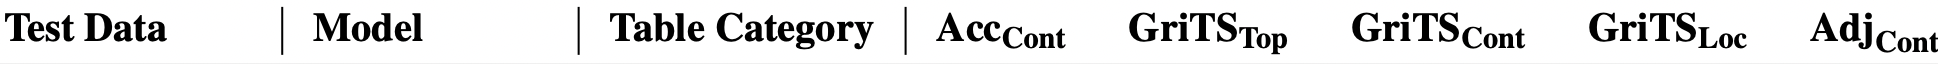

In [ ]:
column_header

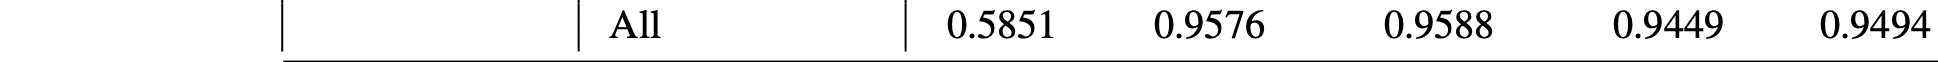

In [ ]:
table_rows[0]

In [ ]:
ext_df = pytesseract.image_to_data(column_header, output_type=Output.DATAFRAME, config="--psm 1")
ext_df = ext_df.dropna(subset=['text'])
ext_df['text'] = ext_df['text'].str.strip()
ext_df = ext_df[ext_df['text'].apply(len) > 1]
ext_df = ext_df.reset_index(drop=True)
extracted_columns = ext_df['text'].values.tolist()
ext_result_df = pd.DataFrame(columns=list(map(lambda x: x, range(len(extracted_columns)))))
ext_result_df.columns = extracted_columns
ext_result_df

,Test,Data,Model,Table,Category,Acccont,GriTStop,GriTScont,GriTSpoc,Adjcont


In [ ]:
extracted_columns

['Test',
 'Data',
 'Model',
 'Table',
 'Category',
 'Acccont',
 'GriTStop',
 'GriTScont',
 'GriTSpoc',
 'Adjcont']

# Post processing

In [ ]:
for table_row in table_rows:
    ext_df = pytesseract.image_to_data(table_row, output_type=Output.DATAFRAME, config="--psm 1")
    ext_df = ext_df.dropna(subset=['text'])
    # ext_df['text'] = ext_df['text'].str.strip()
    # ext_df = ext_df[ext_df['text'].apply(len) > 1]
    ext_df = ext_df.reset_index(drop=True)
    data = dict(zip(extracted_columns, ext_df['text'].values.tolist()))
    for col in extracted_columns:
        if col not in data:
            data[col] = np.nan
    row_df = pd.DataFrame(data=data, index=[0])
    ext_result_df = pd.concat([ext_result_df, row_df])

final_ext_df = pd.DataFrame()
for _, row in ext_result_df.iterrows():
    missing_count = row.isna().sum()
    if missing_count // len(ext_result_df.columns) == 1:
        continue
    row_df = pd.DataFrame(row).T
    final_ext_df = pd.concat([final_ext_df, row_df])

final_ext_df = final_ext_df.reset_index(drop=True)
final_ext_df.head()

,Test,Data,Model,Table,Category,Acccont,GriTStop,GriTScont,GriTSpoc,Adjcont
0,All,0.5851,0.9576,0.9588,0.9449,0.9494,,NaN,NaN,NaN
1,|,Complex,|,0.6944,0.9752,0.9763,0.9654,0.9667,NaN,NaN
2,All,0.7336,0.9762,0.9761,0.9668,0.9681,NaN,NaN,NaN,NaN
3,|,Complex,|,0.2712,0.9257,0.9290,0.9044,0.9162,NaN,NaN
4,Non-Canonical,|,DETR-NC,|,Simple,|,0.8678,0.9872,0.9859,0.9821
